<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-09-14 17:42:02--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2021-09-14 17:42:02 (188 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



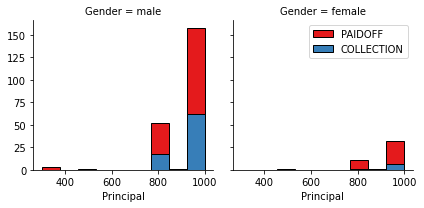

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

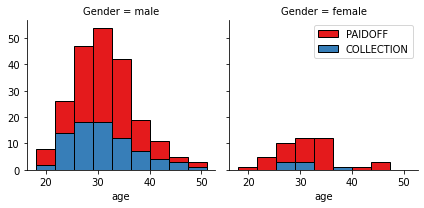

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


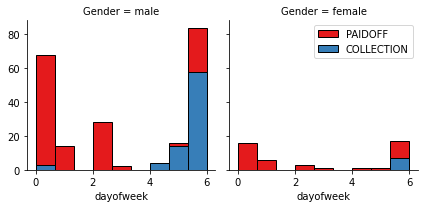

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4)
print("Train Set: ", X_train.shape, y_train.shape)
print("Test Set: ", X_test.shape, y_test.shape)

Train Set:  (276, 8) (276,)
Test Set:  (70, 8) (70,)


[0.67142857 0.65714286 0.71428571 0.68571429 0.75714286 0.71428571
 0.78571429 0.75714286 0.75714286]


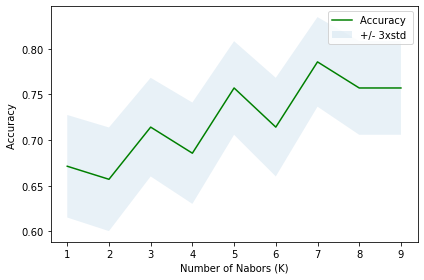

The best accuracy was with 0.7857142857142857 with k= 7


In [36]:
# try with 10 different values of k to find the best one
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = []
for n in range(1,Ks):
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])


print(mean_acc)

# Plotting accuracy for different k-values
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

# Printing different k-values
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1 )

In [37]:
# train model with k=7 since it showed higher accuracy
neigh = KNeighborsClassifier(n_neighbors = 7).fit(X_train,y_train)

yhatk = neigh.predict(X_test)

# Accuracy Evaluation
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhatk))

Train set Accuracy:  0.8079710144927537
Test set Accuracy:  0.7857142857142857


# Decision Tree


In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split

DT = DecisionTreeClassifier(criterion="entropy")
DT

# Split in train and test sets
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

# Training the model with the training data
DT.fit(X_train,y_train)

Train set: (242, 8) (242,)
Test set: (104, 8) (104,)


DecisionTreeClassifier(criterion='entropy')

In [39]:
# Prediction for the testing data
P_DT = DT.predict(X_test)

# Comparing prediction output vs test set output
print(P_DT [0:5])
print(y_test [0:5])

# Accuracy Evaluation
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, P_DT))

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
DecisionTrees's Accuracy:  0.7115384615384616


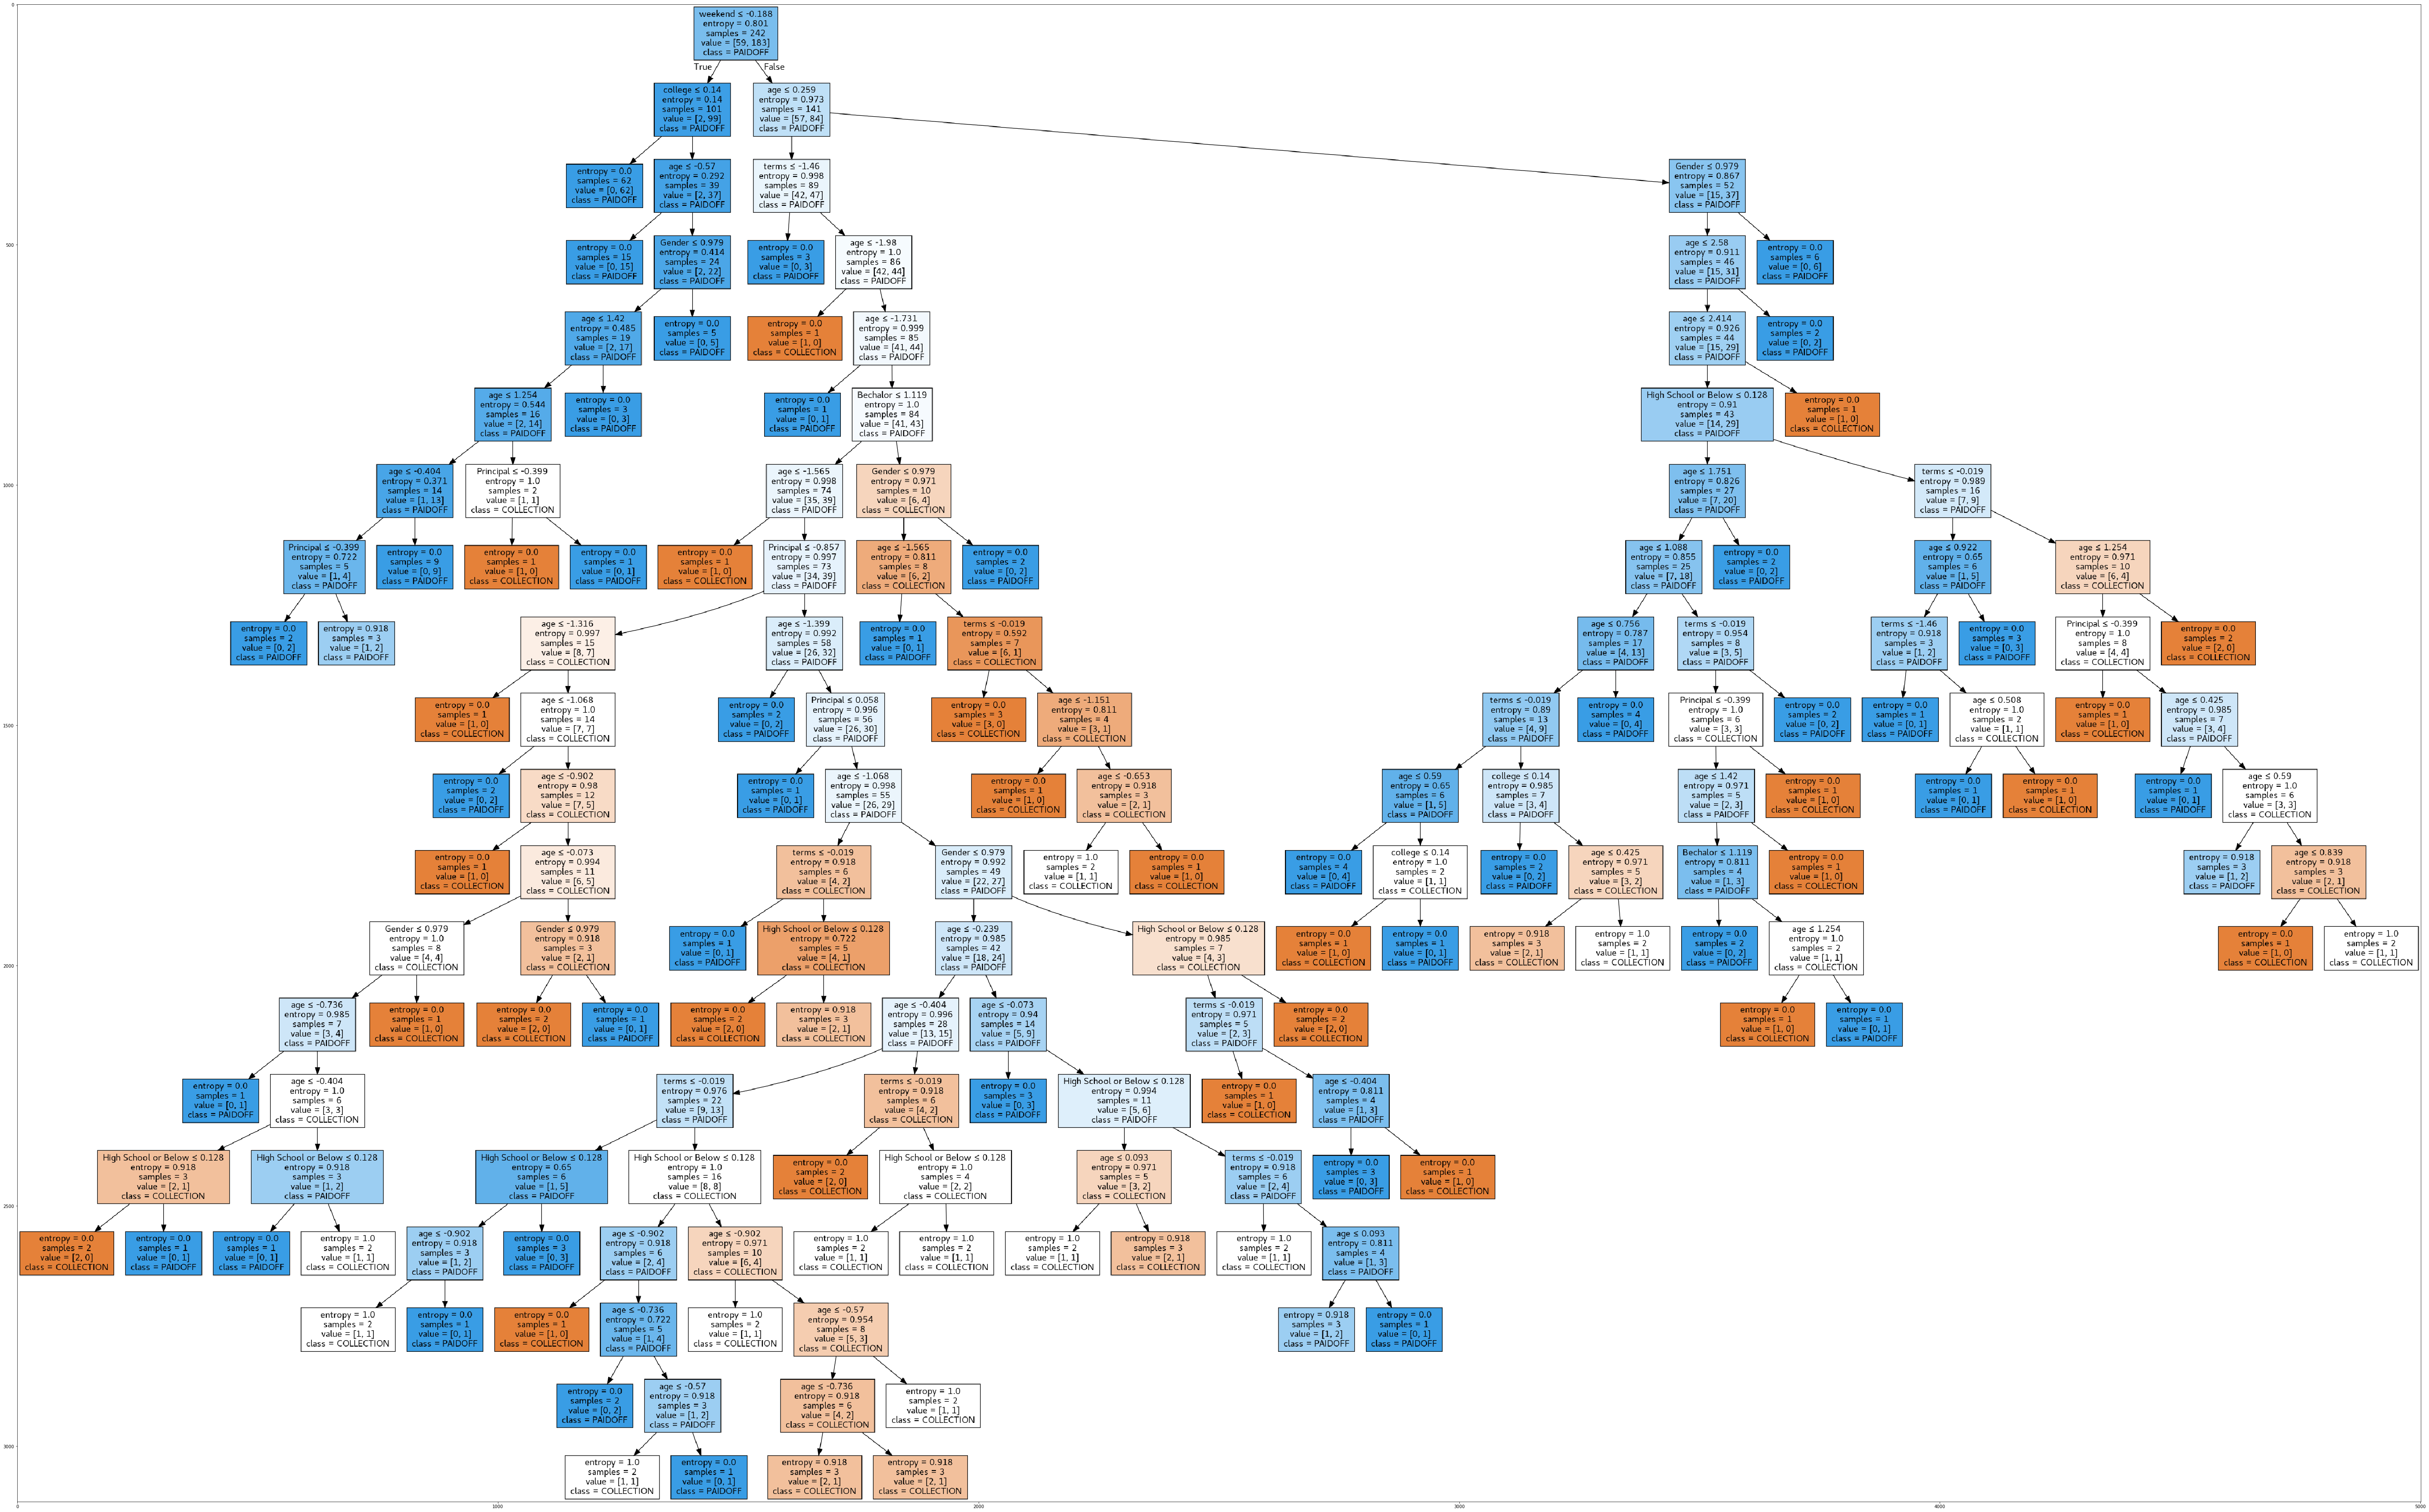

In [44]:
# Visualisation

#!conda install -c conda-forge python-graphviz -y
#!conda install -c conda-forge pydotplus -y

import graphviz 
import pydotplus
import matplotlib.pyplot as plt
from  io import StringIO
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

dot_data = StringIO()
filename = "DT.png"
featureNames = Feature.columns
out=tree.export_graphviz(DT,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# Support Vector Machine


In [45]:
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)


#Testing and training model to find out the best kernel function to use. F1_score has been used to determine model accuracy
Ker = ["linear", "poly", "rbf", "sigmoid"]
Acc = np.zeros((4))

for n in range (0,4):

    #Train Model and Predict best kernel function to use
    clf = svm.SVC(kernel=Ker[n])
    clf.fit(X_train, y_train)
    yhat = clf.predict(X_test)
    Acc[n] = f1_score(y_test, yhat, average='weighted')
    
print("Accuracies:", Acc)

# Printing Kernel function value with best accuracy
print( "The best accuracy was with", Acc.max(), "with ker =", Ker[Acc.argmax()])

Train set: (242, 8) (242,)
Test set: (104, 8) (104,)
Accuracies: [0.6299405  0.66685393 0.65198413 0.61560069]
The best accuracy was with 0.6668539325842696 with ker = poly


In [46]:
# Making the SVM model and training it with polynomial kernel function
kernel_f = 'poly'
clf_KF = svm.SVC(kernel=kernel_f)
clf_KF.fit(X_train, y_train)

# Predicting
yhat = clf_KF.predict(X_test)
print(yhat [0:5])
print(y_test [0:5])

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


In [47]:
# Evaluation

# 1_Computing F1_score
SVM_F1_S = f1_score(y_test, yhat, average='weighted')
print("SVM_F1_Score:",SVM_F1_S)

# 2_Computing Jaccard index
SVM_J_S = jaccard_score(y_test, yhat, average='weighted')
print("SVM_J_Score:",SVM_J_S)

SVM_F1_Score: 0.6668539325842696
SVM_J_Score: 0.5702030812324931


# Logistic Regression


In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import jaccard_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

#Testing and training model to find out the best kernel function to use. F1_score has been used to determine model accuracy
Solver = ["liblinear", "newton-cg", "lbfgs", "sag", "saga"]
Acc = np.zeros((5))


for n in range (0,5):

    #Train Model and Predict best kernel function to use
    LR = LogisticRegression(C=0.01, solver=Solver[n])
    LR.fit(X_train, y_train)
    yhat = LR.predict(X_test)
    Acc[n] = jaccard_score(y_test, yhat, average='weighted')
    
print("Accuracies:", Acc)

# Printing Kernel function value with best accuracy
print( "The best accuracy was with", Acc.max(), "with solver =", Solver[Acc.argmax()])

Train set: (242, 8) (242,)
Test set: (104, 8) (104,)
Accuracies: [0.54663249 0.54816938 0.54816938 0.54816938 0.54816938]
The best accuracy was with 0.5481693786982249 with solver = newton-cg


In [49]:
# Making the Logistic Regression model and training it with solver newton-cg
S = 'newton-cg'
LR_S = LogisticRegression(C=0.01, solver=S)
LR_S.fit(X_train, y_train)

# Predicting
yhat = LR_S.predict(X_test)
yhat_p = LR_S.predict_proba(X_test)
print("yhat:",yhat [0:5])
print("yhat_prob:\n",yhat_p [0:5])
print("y_test:",y_test [0:5])
print(np.where(yhat == 'COLLECTION'))

yhat: ['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
yhat_prob:
 [[0.31415659 0.68584341]
 [0.27998114 0.72001886]
 [0.17369324 0.82630676]
 [0.20026291 0.79973709]
 [0.18174641 0.81825359]]
y_test: ['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
(array([], dtype=int64),)


In [50]:
# Evaluation
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score

# 1_Computing F1_score
LR_F1_S = f1_score(y_test, yhat, average='weighted')
print("LR_F1_Score:",LR_F1_S)

# 2_Computing Jaccard index
LR_J_S = jaccard_score(y_test, yhat, average='weighted')
print("LR_J_Score:",LR_J_S)

LR_F1_Score: 0.6299405014874628
LR_J_Score: 0.5481693786982249


# Model Evaluation using Test set


In [51]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [52]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-09-14 19:20:08--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-09-14 19:20:08 (87.8 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [53]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [54]:
# Tidying data and obtaing test features(X_T) and outcomes(y_T)

#Converting to date time object
test_df['due_date'] = pd.to_datetime(df['due_date'])
test_df['effective_date'] = pd.to_datetime(df['effective_date'])
print("Tidying dates:\n",test_df.head())
print("\n")

# Adding "dayofweek" and "weekend" columns
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
print("dayofweek and weekend columns added:\n",test_df.head())
print("\n")

# Converting males to 0 and females to 1 (binary values)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
print("Gender replaced with 0s(males) and 1s(females):\n",test_df.head())
print("\n")

# Finalizing the Feature data set (also converting categorical variable "Education" to binary variables using One Hot Encoding)
F = test_df[['Principal','terms','age','Gender','weekend']]
F = pd.concat([F,pd.get_dummies(df['education'])], axis=1)
F.drop(['Master or Above'], axis = 1,inplace=True)

#Removing NaN and inf values
F = F[~F.isin([np.nan, np.inf, -np.inf]).any(1)]

print("Test Features data set:\n",F.head())
print(F.columns)
print("\n")

Tidying dates:
    Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           1             1     PAIDOFF       1000     30     2016-09-08   
1           5             5     PAIDOFF        300      7     2016-09-08   
2          21            21     PAIDOFF       1000     30     2016-09-08   
3          24            24     PAIDOFF       1000     30     2016-09-09   
4          35            35     PAIDOFF        800     15     2016-09-09   

    due_date  age             education  Gender  
0 2016-10-07   50              Bechalor  female  
1 2016-10-07   35       Master or Above    male  
2 2016-09-22   43  High School or Below  female  
3 2016-10-08   26               college    male  
4 2016-10-08   29              Bechalor    male  


dayofweek and weekend columns added:
    Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           1             1     PAIDOFF       1000     30     2016-09-08   
1           5             5     PAI

In [55]:
#Selecting X_T and y_T for testing our model

X_T = F
print("X_T before normalizing:\n",X_T[0:5])
print("\n")

X_T = preprocessing.StandardScaler().fit(X_T).transform(X_T)
print("X_T after normalizing:\n",X_T[0:5])
print("\n")

y_T = test_df['loan_status'].values
print("y_T:\n",y_T[0:5])

print ('Test data:', X_T.shape,  y_T.shape)

X_T before normalizing:
    Principal  terms   age  Gender  weekend  Bechalor  High School or Below  \
0     1000.0   30.0  50.0     1.0      0.0         0                     1   
1      300.0    7.0  35.0     0.0      0.0         1                     0   
2     1000.0   30.0  43.0     1.0      0.0         0                     0   
3     1000.0   30.0  26.0     0.0      1.0         0                     0   
4      800.0   15.0  29.0     0.0      1.0         0                     0   

   college  
0        0  
1        0  
2        1  
3        1  
4        1  


X_T after normalizing:
 [[ 0.49362588  0.92844966  3.05981865  1.97714211 -4.12310563 -0.47673129
   1.41421356 -0.92847669]
 [-3.56269116 -1.70427745  0.53336288 -0.50578054 -4.12310563  2.0976177
  -0.70710678 -0.92847669]
 [ 0.49362588  0.92844966  1.88080596  1.97714211 -4.12310563 -0.47673129
  -0.70710678  1.07703296]
 [ 0.49362588  0.92844966 -0.98251057 -0.50578054  0.24253563 -0.47673129
  -0.70710678  1.07703296]

In [56]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

# Obtaining accuracies for the four models

# KNN
KNN_P = neigh.predict(X_T)
KNN_F1_S_P = f1_score(y_T, KNN_P, average='weighted')
print("KNN_F1_Score:",KNN_F1_S_P)
KNN_J_S_P = jaccard_score(y_T, KNN_P, average='weighted')
print("KNN_J_Score:",KNN_J_S_P)
print("\n")

# Decision Tree
DT_P = DT.predict(X_T)
DT_F1_S_P = f1_score(y_T, DT_P, average='weighted')
print("DT_F1_Score:",DT_F1_S_P)
DT_J_S_P = jaccard_score(y_T, DT_P, average='weighted')
print("DT_J_Score:",DT_J_S_P)
print("\n")

# Support Vector Machine
SVM_P = clf_KF.predict(X_T)
SVM_F1_S_P = f1_score(y_T, SVM_P, average='weighted')
print("SVM_F1_Score:",SVM_F1_S_P)
SVM_J_S_P = jaccard_score(y_T, SVM_P, average='weighted')
print("SVM_J_Score:",SVM_J_S_P)
print("\n")

# Logistic Regression
LR_P = LR_S.predict(X_T)
LR_Prob = LR_S.predict_proba(X_T)
LR_F1_S_P = f1_score(y_T, LR_P, average='weighted')
print("LR_F1_Score:",LR_F1_S_P)
LR_J_S_P = jaccard_score(y_T, LR_P, average='weighted')
print("LR_J_Score:",LR_J_S_P)
LR_LL_P = log_loss(y_T, LR_Prob)
print("LR_LogLoss:",LR_LL_P)

KNN_F1_Score: 0.7001989201477693
KNN_J_Score: 0.5730994152046783


DT_F1_Score: 0.6350362011082796
DT_J_Score: 0.47083740632127724


SVM_F1_Score: 0.6704776923582364
SVM_J_Score: 0.5575666163901458


LR_F1_Score: 0.6304176516942475
LR_J_Score: 0.5486968449931412
LR_LogLoss: 0.5566502307170422


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | 0.5731       | 0.7002        | NA      |
| Decision Tree      | 0.4708       | 0.6350        | NA      |
| SVM                | 0.5576       | 0.6705        | NA      |
| LogisticRegression | 0.5487       | 0.6304        | 0.5567       |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
